## Importar openslide

In [1]:
import os

OPENSLIDE_PATH = r'C:\Users\achav\Documents\Osteoartritis\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        print('Using OpenSlide from', openslide.__file__)
else:
    import openslide

Using OpenSlide from c:\Users\achav\Documents\Osteoartritis\venv\Lib\site-packages\openslide\__init__.py


## Seleccionar la imagen que se va a segmentar

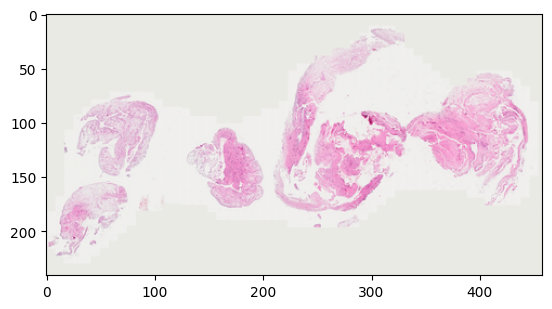

In [2]:
import openslide
import numpy as np
import matplotlib.pyplot as plt

plate_name = "MS-37-23_004"
filename = plate_name + ".svs"
dir_path = f"assets/{plate_name}"
file_path = f"{dir_path}/{filename}"

# Check if file exists
if not os.path.isfile(file_path):
    print(f"File {file_path} not found")

slide = openslide.OpenSlide(file_path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 256, slide.dimensions[1] // 256))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)


### Leer las anotaciones que se hicieron sobre la imagen y clasificarlas por tipo


In [3]:
import xml.etree.ElementTree as ET

path_xml = f"{dir_path}/{plate_name}.xml"

tree = ET.parse(path_xml)
root = tree.getroot()

# Obtener las coordenadas de las anotaciones
coordinates = { i: [] for i in range(1,4) }
print(coordinates)
for annotation in root.findall(".//Annotation"):
    for region in annotation.findall(".//Region"):
        coordinates_region = []
        region_text = int(region.attrib['Text'])
        # print("Region:", region_text)
        for vertex in region.findall(".//Vertex"):
            x = int(float(vertex.attrib['X']))
            y = int(float(vertex.attrib['Y']))
            coordinates_region.append((x, y))
        coordinates[region_text].append(coordinates_region)
        
for region in coordinates:
    print(f"Region {region}: {len(coordinates[region])} annotations")
    
# for coordinates_region in coordinates:
#     print(coordinates_region)
    

{1: [], 2: [], 3: []}
Region 1: 5 annotations
Region 2: 10 annotations
Region 3: 4 annotations


## Convertir las anotaciones a la escala adecuada para mostrarlas

In [4]:
# Transform slide to numpy array
import cv2

level = 2
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = np.array(image)
image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

print("Image size: ", image.size)

# levels info
print("Level count: ", slide.level_count)
print("Level dimensions: ", slide.level_dimensions)
print(f"Level dimensiones[{level}]: ", slide.level_dimensions[level])
print("Level downsamples: ", slide.level_downsamples)

downsample_factor = 16

# Transform annotations to level 2 (downsampled by 16)
coordenadas_anotaciones_nivel_2 = { i : [] for i in range(1,4) }
for region, coordenadas_region in coordinates.items():
    for coordenadas in coordenadas_region:
        coordenadas_nivel_2 = [(x // downsample_factor, y // downsample_factor) for x, y in coordenadas]
        coordenadas_anotaciones_nivel_2[region].append(coordenadas_nivel_2)
    
print(coordinates)


Image size:  84965853
Level count:  4
Level dimensions:  ((117497, 61726), (29374, 15431), (7343, 3857), (3671, 1928))
Level dimensiones[2]:  (7343, 3857)
Level downsamples:  (1.0, 4.000081826470152, 16.00242771057686, 32.011185149726856)
{1: [[(49767, 34476), (49784, 34476), (49800, 34476), (49816, 34476), (49816, 34492), (49833, 34492), (49833, 34509), (49849, 34509), (49849, 34525), (49865, 34525), (49882, 34541), (49898, 34558), (49898, 34574), (49914, 34574), (49931, 34590), (49947, 34607), (49964, 34623), (49980, 34639), (49996, 34656), (49996, 34672), (50013, 34688), (50013, 34705), (50029, 34705), (50029, 34721), (50029, 34738), (50045, 34738), (50045, 34754), (50045, 34770), (50062, 34770), (50062, 34787), (50062, 34803), (50062, 34819), (50078, 34819), (50078, 34836), (50078, 34852), (50078, 34868), (50094, 34885), (50094, 34901), (50094, 34917), (50111, 34917), (50111, 34934), (50111, 34950), (50127, 34967), (50127, 34983), (50127, 34999), (50143, 35016), (50143, 35032), (50

## Dibujar las anotaciones escaladas en la imagen a escala

In [5]:
# Draw the annotations on the slide
for region, coordenadas_region in coordenadas_anotaciones_nivel_2.items():
    for coordenadas in coordenadas_region:

        if region == 1:
            cv2.polylines(image, [np.array(coordenadas)], isClosed=True, color=(0, 255, 0), thickness=10)
        elif region == 2:
            cv2.polylines(image, [np.array(coordenadas)], isClosed=True, color=(0, 0, 255), thickness=10)
        elif region == 3:
            cv2.polylines(image, [np.array(coordenadas)], isClosed=True, color=(0, 100, 100), thickness=10)


## Presentar la imagen

(3857, 7343, 3)


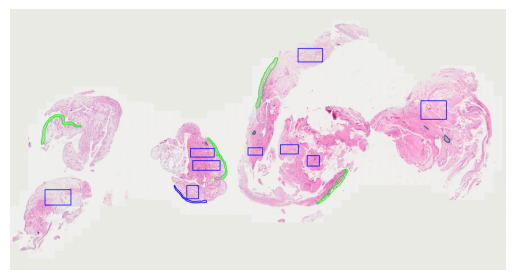

In [6]:
print(image.shape)

# Display the slide with the annotations
plt.imshow(image)

plt.axis('off')  # Hide axis
plt.show()

## Crear el dataset por clase y por imagen

In [7]:
# Create a dataset of images from the slide depending on the annotations
import os
import cv2

# Create a directory to store the images of class A
class_A_dir = os.path.join(dir_path, "class_A") ## Línea de sinoviocitos (Marcado en la imagen con text=1)
if not os.path.exists(class_A_dir):
    os.makedirs(class_A_dir)

# Create a directory to store the images of class B
class_B_dir = os.path.join(dir_path, "class_B") ## Línea de estroma (Marcado en la imagen con text=2)
if not os.path.exists(class_B_dir):
    os.makedirs(class_B_dir)

# Create a directory to store the images of class C
class_C_dir = os.path.join(dir_path, "class_C") ## Infiltrados celulares (Marcado en la imagen con text=3)
if not os.path.exists(class_C_dir):
    os.makedirs(class_C_dir)

# Create a directory to store the images of class D
class_D_dir = os.path.join(dir_path, "class_D") ## Ninguna de las anteriores 
if not os.path.exists(class_D_dir):
    os.makedirs(class_D_dir)

# Create a directory to store the masks
masks_dir = os.path.join(dir_path, "masks")
if not os.path.exists(masks_dir):
    os.makedirs(masks_dir)


## Creación de máscaras por tipo de región

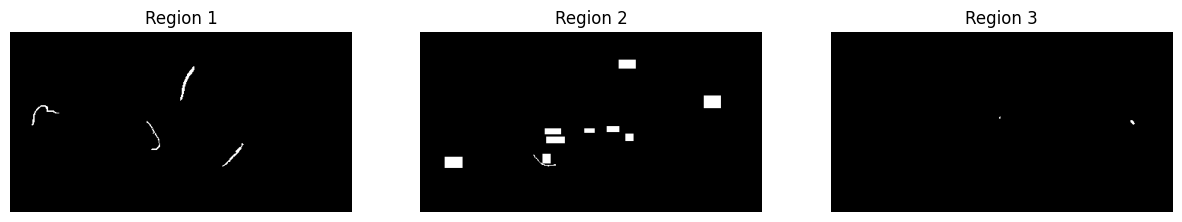

In [8]:
## Convert the annotations to a mask
level = 0
masks = []

for region, coordinates_region in coordinates.items():
    mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]), dtype=np.uint8)
    for polygon in coordinates_region:
        polygon = np.array(polygon)
        cv2.fillPoly(mask, [polygon], color=255)
    mask_path = os.path.join(masks_dir, f"{plate_name}_mask_level_{level}_region_{region}.png")
    cv2.imwrite(mask_path, mask)

    # Create a thumbnail of the mask
    mask_thumbnail = cv2.resize(mask, (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_thumbnail_path = os.path.join(masks_dir, f"{plate_name}_mask_level_{level}_region_{region}_thumbnail.png")

    masks.append(mask_thumbnail)
    del mask


# Plotea las tres imágenes al mismo tiempo
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, mask_thumbnail in enumerate(masks):
    axs[i].imshow(mask_thumbnail, cmap='gray')
    axs[i].set_title(f'Region {i+1}')
    axs[i].axis('off')

## make a sound when the process is finished
import winsound
frequency = 1760  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Crear la máscara de todas las regiones

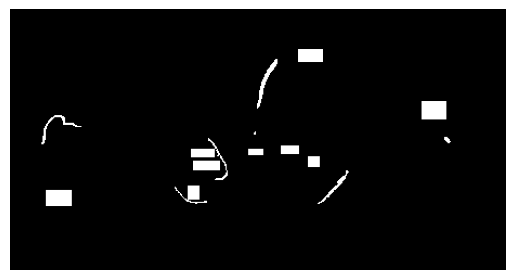

In [9]:
mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]), dtype=np.uint8)
for region, coordinates_region in coordinates.items():
    for polygon in coordinates_region:
        polygon = np.array(polygon)
        cv2.fillPoly(mask, [polygon], color=255)
mask_path = os.path.join(masks_dir, f"{plate_name}_mask_level_{level}_full.png")
cv2.imwrite(mask_path, mask)

# Create a thumbnail of the mask
mask_thumbnail = cv2.resize(mask, (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)
mask_thumbnail_path = os.path.join(masks_dir, f"{plate_name}_mask_level_{level}_region_{region}_thumbnail.png")

masks.append(mask_thumbnail)

# Plotea la máscara
plt.imshow(mask_thumbnail, cmap='gray')
plt.axis('off')
plt.show()

    

## Seleccionar la anotación para extraer los campos de visión

In [10]:
# Get the size of the images
size = 1024

del mask

for region, coordinates_region in coordinates.items():
    print(f"Working on region {region}")
    if region == 1:
        dir = class_A_dir
    elif region == 2:
        dir = class_B_dir
    else:
        dir = class_C_dir

    mask = np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]), dtype=np.uint8)
    for polygon in coordinates_region:
        polygon = np.array(polygon)
        cv2.fillPoly(mask, [polygon], color=255)

        # Find the bounding box of the annotations
        x_min = min(x for x, y in polygon)
        x_max = max(x for x, y in polygon)
        y_min = min(y for x, y in polygon)
        y_max = max(y for x, y in polygon)

        # Iterate over the bounding box of the annotations and extract the images
        for x in range(x_min, x_max, 3*size//4):
            for y in range(y_min, y_max, 3*size//4):
                # print(x, y)
                # Extract the image
                image = np.array(slide.read_region((x, y), 0, (size, size)))
                # Check if more than 80 % of the image is inside the annotations
                mask_region = mask[y:y + size, x:x + size]
                if np.count_nonzero(mask_region) > 0.8 * size * size:
                    print("Inside annotation: ", x, y)
                    # Save the image to the chosen directory
                    image_path = os.path.join(dir, f"{x}_{y}.png")
                    cv2.imwrite(image_path, image)
        ## Limpiar memoria de las variables
        del mask_region, image
    del mask

    print(f"Region {region}: {len(os.listdir(dir))} images")

winsound.Beep(frequency, duration)


Working on region 1
Inside annotation:  59013 17691
Inside annotation:  59013 18459
Inside annotation:  59013 19227
Inside annotation:  59781 16155
Inside annotation:  60549 14619
Inside annotation:  61317 13083
Inside annotation:  62085 12315
Inside annotation:  77975 39448
Region 1: 8 images
Working on region 2
Inside annotation:  70398 34673
Inside annotation:  70398 35441
Inside annotation:  70398 36209
Inside annotation:  71166 34673
Inside annotation:  71166 35441
Inside annotation:  71166 36209
Inside annotation:  71934 34673
Inside annotation:  71934 35441
Inside annotation:  71934 36209
Inside annotation:  64056 32099
Inside annotation:  64056 32867
Inside annotation:  64824 32099
Inside annotation:  64824 32867
Inside annotation:  65592 32099
Inside annotation:  65592 32867
Inside annotation:  66360 32099
Inside annotation:  66360 32867
Inside annotation:  67128 32099
Inside annotation:  67128 32867
Inside annotation:  68237 9342
Inside annotation:  68237 10110
Inside annotat

## Reducir el tamaño de las imágenes

In [11]:
import pathlib
import cv2

data_dir = pathlib.Path(dir_path)

image_count = len(list(data_dir.glob('**/*.png')))

class_a = list(data_dir.glob('class_A/**/*.png'))
class_b = list(data_dir.glob('class_B/**/*.png'))
class_c = list(data_dir.glob('class_C/**/*.png'))

print(len(class_a))
print(len(class_b))
print(len(class_c))

print(image_count)

# Set the size of the images
size = 128

# Create a subdirectory for the resized images
resized_dir = os.path.join(dir_path, "resized")
if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

# Resize the images in a subdirectory called resized plus the class name
for class_dir in [class_A_dir, class_B_dir, class_C_dir]:
    class_name = os.path.basename(class_dir)
    resized_class_dir = os.path.join(resized_dir, class_name)
    if not os.path.exists(resized_class_dir):
        os.makedirs(resized_class_dir)
    for image_path in os.listdir(class_dir):
        image = cv2.imread(os.path.join(class_dir, image_path))
        image = cv2.resize(image, (size, size))
        cv2.imwrite(os.path.join(resized_class_dir, image_path), image)



8
160
0
172
